In [3]:
import os
WORKSPACE_PATH = "/Users/interview/Router"
os.chdir(WORKSPACE_PATH)

In [4]:
%load_ext autoreload
%autoreload 2
import os
from router.embedding_router import generate_embeddings_sentence_transformer, return_top_k, generate_predictions_sentence_transformer, run_evals, plot_results, plot_results_comparisons
from router.evals import Evals
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
tool_descriptions_path = WORKSPACE_PATH + "/data/tool_descriptions_v1.json"


In [7]:
model_path = WORKSPACE_PATH + "/models/checkpoint-21000"
# model_path = 'nomic-ai/nomic-embed-text-v1.5'

def main(model_path, score_thresholds, top_k_values):
    tool_descriptions_path = WORKSPACE_PATH + "/data/tool_descriptions_v1.json"
    evals_path = WORKSPACE_PATH + "/data/evals_test_500_v1.json"
    evals = Evals(evals_path)
    predicted_integrations_list = generate_predictions_sentence_transformer(model_path, evals, tool_descriptions_path)

    results_integrations = []
    for score_threshold in score_thresholds:
        result_for_threshold_integrations = []
        for top_k in top_k_values:
            r_integrations = run_evals(evals, predicted_integrations_list, top_k=top_k, score_threshold=score_threshold)
            result_for_threshold_integrations.append(r_integrations)
        results_integrations.append(result_for_threshold_integrations)
    
    return results_integrations



Length of tools_descriptions: 16
Length of integrations_name: 16


<All keys matched successfully>


embeddings: 1243.70ms
embeddings: 518.26ms
embeddings: 133.50ms
embeddings: 263.97ms
embeddings: 273.51ms
embeddings: 11.54ms
embeddings: 11.39ms
embeddings: 11.07ms
embeddings: 60.30ms
embeddings: 80.47ms
embeddings: 11.62ms
embeddings: 11.69ms
embeddings: 45.46ms
embeddings: 268.98ms
embeddings: 11.66ms
embeddings: 13.44ms
embeddings: 11.91ms
embeddings: 44.17ms
embeddings: 279.86ms
embeddings: 54.51ms
embeddings: 12.20ms
embeddings: 55.51ms
embeddings: 274.10ms
embeddings: 46.10ms
embeddings: 11.48ms
embeddings: 10.87ms
embeddings: 11.27ms
embeddings: 45.74ms
embeddings: 11.89ms
embeddings: 260.84ms
embeddings: 11.77ms
embeddings: 12.13ms
embeddings: 11.11ms
embeddings: 11.97ms
embeddings: 45.32ms
embeddings: 11.81ms
embeddings: 11.75ms
embeddings: 15.36ms
embeddings: 11.61ms
embeddings: 10.71ms
embeddings: 11.37ms
embeddings: 15.31ms
embeddings: 11.24ms
embeddings: 11.64ms
embeddings: 12.49ms
embeddings: 11.06ms
embeddings: 11.08ms
embeddings: 11.42ms
embeddings: 46.13ms
embeddings

A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- configuration_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/nomic-ai/nomic-bert-2048:
- modeling_hf_nomic_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
<All keys matched successfully>


embeddings: 200.35ms
embeddings: 20.40ms
embeddings: 12.61ms
embeddings: 11.39ms
embeddings: 16.88ms
embeddings: 11.18ms
embeddings: 11.51ms
embeddings: 11.18ms
embeddings: 16.50ms
embeddings: 12.25ms
embeddings: 11.06ms
embeddings: 11.61ms
embeddings: 11.42ms
embeddings: 11.54ms
embeddings: 11.25ms
embeddings: 11.84ms
embeddings: 11.99ms
embeddings: 16.88ms
embeddings: 13.12ms
embeddings: 17.85ms
embeddings: 12.34ms
embeddings: 16.39ms
embeddings: 11.62ms
embeddings: 11.79ms
embeddings: 11.63ms
embeddings: 11.04ms
embeddings: 11.37ms
embeddings: 16.47ms
embeddings: 11.51ms
embeddings: 15.61ms
embeddings: 11.16ms
embeddings: 19.55ms
embeddings: 15.92ms
embeddings: 20.32ms
embeddings: 17.53ms
embeddings: 12.29ms
embeddings: 11.37ms
embeddings: 11.02ms
embeddings: 11.85ms
embeddings: 10.95ms
embeddings: 15.74ms
embeddings: 15.65ms
embeddings: 11.18ms
embeddings: 15.73ms
embeddings: 11.48ms
embeddings: 15.57ms
embeddings: 15.37ms
embeddings: 12.73ms
embeddings: 16.66ms
embeddings: 12.00ms

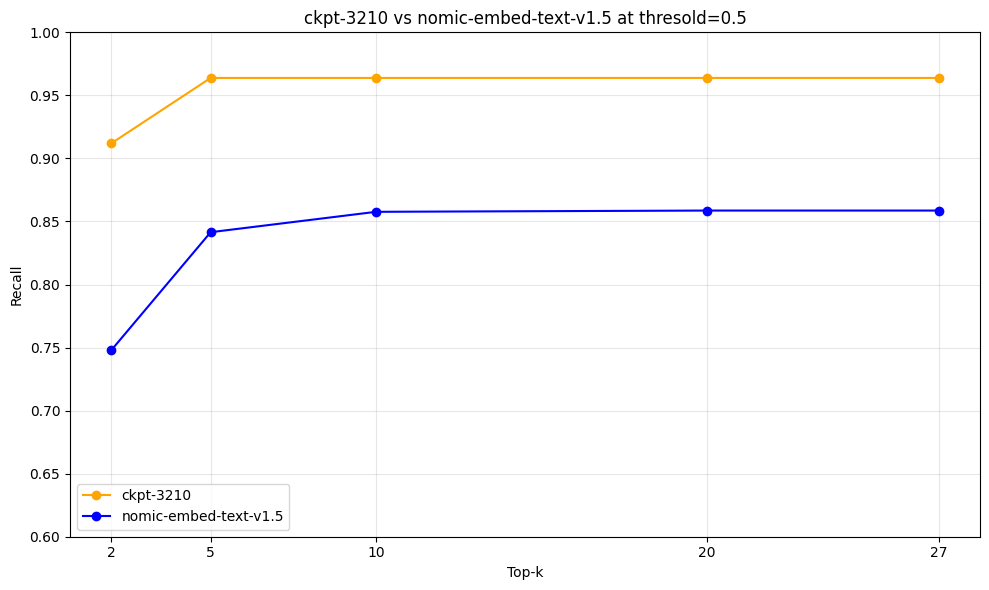

In [8]:
score_thresholds = [0.5]
top_k_values = [2, 5, 10, 20, 27]

results_integrations_ckpt = main(WORKSPACE_PATH + "/models/checkpoint-21000", score_thresholds, top_k_values)
results_integrations_base = main("nomic-ai/nomic-embed-text-v1.5", score_thresholds, top_k_values)
plot_results_comparisons(results_integrations_ckpt, results_integrations_base, "ckpt-3210",  "nomic-embed-text-v1.5", score_thresholds[0], top_k_values, save_fig=False)

# plot_results(results_integrations_1, "nomic-embed-text-v1.5-router", score_thresholds, top_k_values, save_fig=True)
# plot_results(results_integrations_2, "nomic-embed-text-v1.5", score_thresholds, top_k_values, save_fig=True)


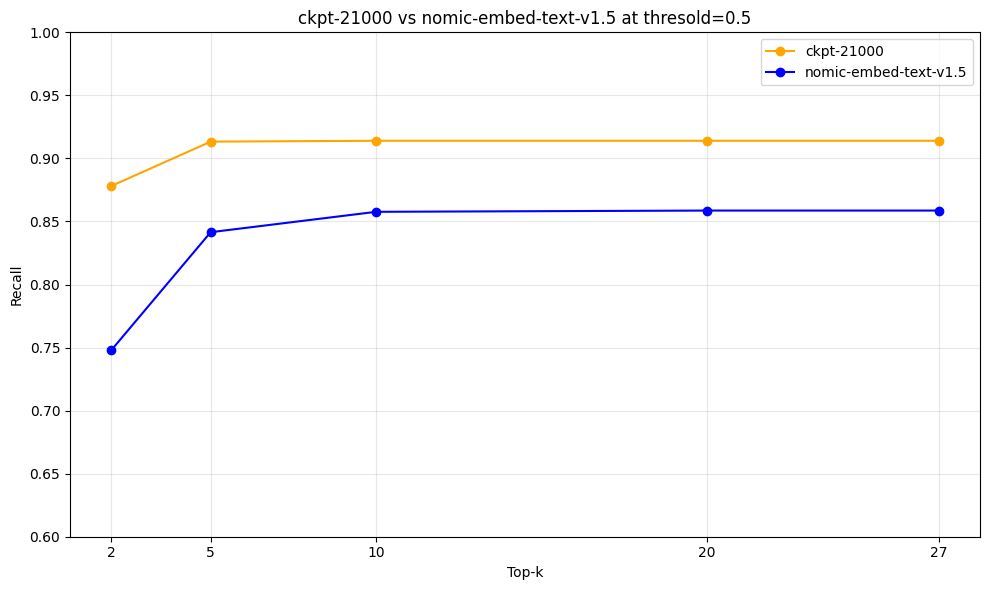

In [5]:
plot_results_comparisons(results_integrations_ckpt, results_integrations_base, "ckpt-21000",  "nomic-embed-text-v1.5", score_thresholds[0], top_k_values, save_fig=True)


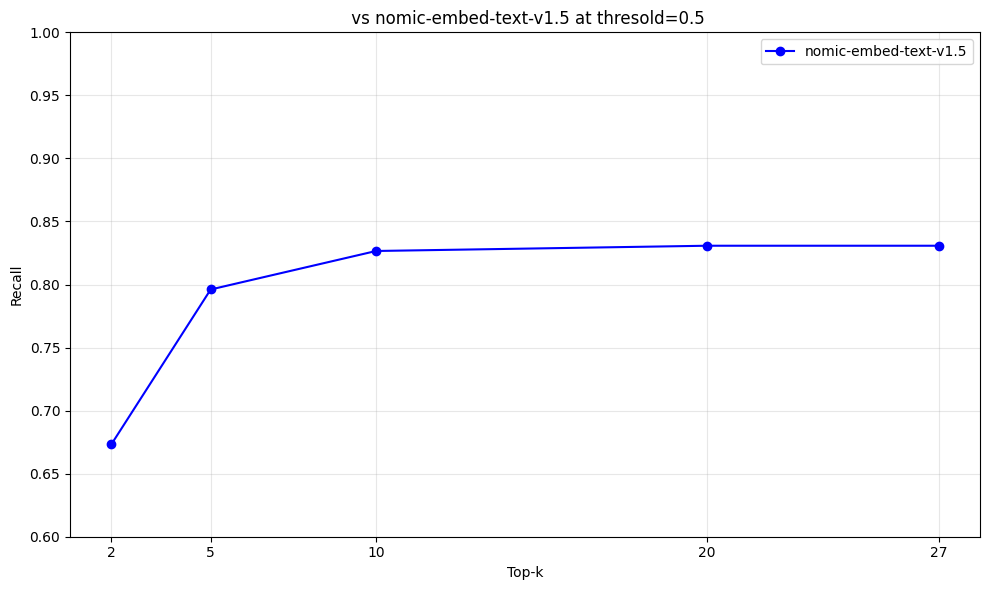

In [89]:
plot_results_comparisons(None, results_integrations_base, "",  "nomic-embed-text-v1.5", score_thresholds[0], top_k_values, save_fig=True)
